In [172]:
import pandas as pd
import numpy as np
import requests
import csv
import re
import tweepy
from pandas.io.json import json_normalize
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statsmodels.api as sm

## Gather Data ##

### Get the provided WeRateDogs Twitter archive ###

In [173]:
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [174]:
# Convert tweet_id from int to string
df_twitter_archive['tweet_id'] = df_twitter_archive['tweet_id'].astype(str)
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(2), o

### Obtain the Tweet Image Predictions ###

In [175]:
response = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

In [176]:
response.headers.get('content-type')

'text/tab-separated-values; charset=utf-8'

In [177]:
with open('image-predictions.tsv', 'wb') as file:
    # A chunk of 128 bytes
    for chunk in response:
        file.write(chunk)

In [178]:
df_predictions = pd.read_csv('image-predictions.tsv', sep='\t')
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Using tweepy to get retweet count and favorite ("like") count ###

Commenting out the code that I used to obtain the tweet information using tweepy. Also getting rid of my account specific keys, secrets and tokens.

In [179]:
# consumer_key = '<My consumer key>'
# consumer_secret = '<My consumer secret>'
# access_token = '<My access Token>'
# access_secret = '<My access secret>'

In [180]:
#auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_secret)
#api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [181]:
#for index, row in df_twitter_archive.iterrows():
#    try:
#        tweet = api.get_status(row['tweet_id'], tweet_mode='extended')
#        with open('tweet_json.txt', 'a') as outfile:  
#            json.dump(tweet._json, outfile)
#            outfile.write("\n")
#    except Exception as e:
#        print( "Error: %s" % str(e) )
    

In [182]:
df_tweet_json = None
    
df_tweet_json = pd.read_json('tweet_json.txt', lines=True)

In [183]:
df_tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 32 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2339 non-null datetime64[ns]
display_text_range               2339 non-null object
entities                         2339 non-null object
extended_entities                2065 non-null object
favorite_count                   2339 non-null int64
favorited                        2339 non-null bool
full_text                        2339 non-null object
geo                              0 non-null float64
id                               2339 non-null int64
id_str                           2339 non-null int64
in_reply_to_screen_name          77 non-null object
in_reply_to_status_id            77 non-null float64
in_reply_to_status_id_str        77 non-null float64
in_reply_to_user_id              77 non-null float64
in_reply_to_user_id_str          77 n

## Assess ##

### Assessing the provided twitter archive ###

In [184]:
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [185]:
df_twitter_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8,10,None,None,None,None,None


In [186]:
print(df_twitter_archive.doggo.unique())
print(df_twitter_archive.floofer.unique())
print(df_twitter_archive.puppo.unique())
print(df_twitter_archive.pupper.unique())

['None' 'doggo']
['None' 'floofer']
['None' 'puppo']
['None' 'pupper']


In [187]:
print(df_twitter_archive.doggo.value_counts())
print(df_twitter_archive.floofer.value_counts())
print(df_twitter_archive.puppo.value_counts())
print(df_twitter_archive.pupper.value_counts())

None     2259
doggo    97  
Name: doggo, dtype: int64
None       2346
floofer    10  
Name: floofer, dtype: int64
None     2326
puppo    30  
Name: puppo, dtype: int64
None      2099
pupper    257 
Name: pupper, dtype: int64


In [188]:
pd.set_option('display.max_colwidth', -1)
df_twitter_archive.loc[(df_twitter_archive['doggo'] == 'doggo') & (df_twitter_archive['floofer'] == 'floofer')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",11,10,None,doggo,floofer,None,None


In [189]:
df_twitter_archive.loc[(df_twitter_archive['puppo'] == 'puppo') & (df_twitter_archive['floofer'] == 'floofer')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [190]:
df_twitter_archive.loc[(df_twitter_archive['pupper'] == 'pupper') & (df_twitter_archive['floofer'] == 'floofer')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [191]:
df_twitter_archive.loc[(df_twitter_archive['doggo'] == 'doggo') & (df_twitter_archive['puppo'] == 'puppo')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453814013952/photo/1,13,10,None,doggo,None,None,puppo


In [192]:
#pd.set_option('display.max_colwidth', -1)
df_twitter_archive.loc[(df_twitter_archive['doggo'] == 'doggo') & (df_twitter_archive['pupper'] == 'pupper')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686764523521/video/1,13,10,Dido,doggo,None,pupper,None
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460588765185/photo/1,12,10,None,doggo,None,pupper,None
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048156610565/photo/1,11,10,None,doggo,None,pupper,None
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/801115127852503040/photo/1,https://twitter.com/dog_rates/status/801115127852503040/photo/1",12,10,Bones,doggo,None,pupper,None
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/785639753186217984/photo/1,https://twitter.com/dog_rates/status/785639753186217984/photo/1",10,10,Pinot,doggo,None,pupper,None
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>","Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,"https://twitter.com/dog_rates/status/733109485275860992/photo/1,https://twitter.com/dog_rates/status/733109485275860992/photo/1",12,10,None,doggo,None,pupper,None
822,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,"https://twitter.com/dog_rates/status/741067306818797568/photo/1,https://twitter.com/dog_rates/status/741067306818797568/photo/1",12,10,just,doggo,None,pupper,None
889,759793422261743616,NaN,NaN,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/759793422261743616/photo/1,https://twitter.com/dog_rates/status/759793422261743616/photo/1",12,10,Maggie,doggo,Non

In [193]:
df_twitter_archive.name.unique()

array(['Phineas', 'Tilly', 'Archie', 'Darla', 'Franklin', 'None', 'Jax',
       'Zoey', 'Cassie', 'Koda', 'Bruno', 'Ted', 'Stuart', 'Oliver', 'Jim',
       'Zeke', 'Ralphus', 'Canela', 'Gerald', 'Jeffrey', 'such', 'Maya',
       'Mingus', 'Derek', 'Roscoe', 'Waffles', 'Jimbo', 'Maisey', 'Lilly',
       'Earl', 'Lola', 'Kevin', 'Yogi', 'Noah', 'Bella', 'Grizzwald',
       'Rusty', 'Gus', 'Stanley', 'Alfy', 'Koko', 'Rey', 'Gary', 'a',
       'Elliot', 'Louis', 'Jesse', 'Romeo', 'Bailey', 'Duddles', 'Jack',
       'Emmy', 'Steven', 'Beau', 'Snoopy', 'Shadow', 'Terrance', 'Aja',
       'Penny', 'Dante', 'Nelly', 'Ginger', 'Benedict', 'Venti', 'Goose',
       'Nugget', 'Cash', 'Coco', 'Jed', 'Sebastian', 'Walter', 'Sierra',
       'Monkey', 'Harry', 'Kody', 'Lassie', 'Rover', 'Napolean', 'Dawn',
       'Boomer', 'Cody', 'Rumble', 'Clifford', 'quite', 'Dewey', 'Scout',
       'Gizmo', 'Cooper', 'Harold', 'Shikha', 'Jamesy', 'Lili', 'Sammy',
       'Meatball', 'Paisley', 'Albus', 'Neptune', '

In [194]:
# There are some names that don't seem right
invalid_names = df_twitter_archive[df_twitter_archive.name.str[0].str.islower()].name
print(invalid_names.unique())
print(invalid_names.count())

['such' 'a' 'quite' 'not' 'one' 'incredibly' 'mad' 'an' 'very' 'just' 'my'
 'his' 'actually' 'getting' 'this' 'unacceptable' 'all' 'old' 'infuriating'
 'the' 'by' 'officially' 'life' 'light' 'space']
109


In [195]:
df_twitter_archive[df_twitter_archive.name.str[0].str.islower()][['text', 
                                                                'name']]

,text,name
22,I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,such
56,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,a
118,RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…,quite
169,We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9,quite
193,"Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x",quite
335,There's going to be a dog terminal at JFK Airport. This is not a drill. 10/10 \nhttps://t.co/dp5h9bCwU7,not
369,"Occasionally, we're sent fantastic stories. This is one of them. 14/10 for Grace https://t.co/bZ4axuH6OK",one
542,We only rate dogs. Please stop sending in non-canines like this Freudian Poof Lion. This is incredibly frustrating... 11/10 https://t.co/IZidSrBvhi,incredibly
649,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,a
682,RT @dog_rates: Say hello to mad pupper. You know what you did. 13/10 would pet until no longer furustrated https://t.co/u1ulQ5heLX,mad


In [196]:
df_twitter_archive[df_twitter_archive.text.str.contains('name is')][['text', 
                                                                'name']]

,text,name
35,I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk,None
168,Sorry for the lack of posts today. I came home from school and had to spend quality time with my puppo. Her name is Zoey and she's 13/10 https://t.co/BArWupFAn0,None
843,His name is Charley and he already has a new set of wheels thanks to donations. I heard his top speed was also increased. 13/10 for Charley,None
852,This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB,my
1678,We normally don't rate bears but this one seems nice. Her name is Thea. Appears rather fluffy. 10/10 good bear https://t.co/fZc7MixeeT,None
1734,This pup's name is Sabertooth (parents must be cool). Ears for days. Jumps unannounced. 9/10 would pet diligently https://t.co/iazoiNUviP,None
2267,Another topnotch dog. His name is Big Jumpy Rat. Massive ass feet. Superior tail. Jumps high af. 12/10 great pup https://t.co/seESNzgsdm,None
2287,This is a Dasani Kingfisher from Maine. His name is Daryl. Daryl doesn't like being swallowed by a panda. 8/10 https://t.co/jpaeu6LNmW,a
2313,This is Lugan. He is a Bohemian Rhapsody. Very confused dog. Thinks his name is Rocky. Not amused by the snows 10/10 https://t.co/tI3uFLDHBI,Lugan


In [197]:
df_twitter_archive.loc[(['pupper'] == 'pupper') & (df_twitter_archive['puppo'] == 'puppo')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [198]:
df_twitter_archive.rating_denominator.unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2])

In [199]:
df_twitter_archive[df_twitter_archive.rating_denominator != 10][['text', 
                                                                'rating_numerator',
                                                               'rating_denominator']]

,text,rating_numerator,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


In [200]:
df_twitter_archive.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88])

In [201]:
df_twitter_archive[df_twitter_archive.rating_numerator >= 20][['text', 
                                                                'rating_numerator',
                                                               'rating_denominator']]

,text,rating_numerator,rating_denominator
188,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,420,10
189,"@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",666,10
290,@markhoppus 182/10,182,10
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
340,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150


In [202]:
df_twitter_archive.loc[[1274]]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1274,709198395643068416,NaN,NaN,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",NaN,NaN,NaN,https://twitter.com/dog_rates/status/709198395643068416/photo/1,45,50,None,None,None,None,None


In [203]:
# Checking the tweet replies. Do that have image urls?
df_twitter_archive[df_twitter_archive['in_reply_to_status_id'].notnull()][['text',
                                                                           'expanded_urls', 'name']]

,text,expanded_urls,name
30,@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,None
55,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,None
64,@RealKentMurphy 14/10 confirmed,NaN,None
113,@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,None
148,"@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,None
149,"Ladies and gentlemen... I found Pipsy. He may have changed his name to Pablo, but he never changed his love for the sea. Pupgraded to 14/10 https://t.co/lVU5GyNFen",https://twitter.com/dog_rates/status/863079547188785154/photo/1,None
179,@Marc_IRL pixelated af 12/10,NaN,None
184,"THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY HI AFTER ALL. PUPGRADED TO A 14/10. WOULD BE AN HONOR TO FLY WITH https://t.co/p1hBHCmWnA",https://twitter.com/dog_rates/status/856526610513747968/photo/1,None
186,@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10,NaN,None
188,@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,None


#### Tidiness Issues ####
<br>
1) The doggo, puppo, pupper, floofer can me merged into a single column called dog_stage.
<br>
2) Add the retweet and like counts from the twitter json onto the Twitter Archive dataframe to complete it.

#### Quality Issues ####
<br>
1) Remove re-tweets. Remove all entries with text starting with "RT @"
<br>
2) Some entries have invalid names like just, such, a, an etc. Some of them have a name specified preceded with "name is". Replace them with the given name. Be careful of entry 2313, do not replace the name Lugan. Replace the rest with None.
<br>
3) Entry number 889 seems to be a picture of 2 dogs - Maggie and Lila. Only one name is provided. Add Lila
<br>
4) Entry number 1274 has 4 names Cletus, Jerome, Alejandro, Burp and Titson. Replace None with the 4 names
<br>
5) Entry 1068 should have a rating 14/10. Not 9/11
<br>
6) Entry 1662 should have a rating 10/10 not 7/11
<br>
7) Entry 2336 should have a rating 9/10 not 1/2
<br>
8) Entries 340, 763 and 1712, have fractional ratings. Round them to the nearest integer. Ignore this for entry 340 as it is a retweet.

### Assessing the predictions file entries ###

In [204]:
df_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [205]:
df_predictions.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [206]:
# Checking to see if there are any tweet_ids with multiple images have multiple entries.
print(any(df_predictions['tweet_id'].duplicated()))

False


### Quality Issues ###
1) Will convert the tweet_id from int64 to string as the tweet_id in df_twitter_archive was converted to string for obtaining the tweets from twitter

### Assessing the Twitter JSON dataframe ###

In [207]:
df_tweet_json[['id', 'id_str']]

,id,id_str
0,892420643555336193,892420643555336192
1,892177421306343426,892177421306343424
2,891815181378084864,891815181378084864
3,891689557279858688,891689557279858688
4,891327558926688256,891327558926688256
5,891087950875897856,891087950875897856
6,890971913173991426,890971913173991424
7,890729181411237888,890729181411237888
8,890609185150312448,890609185150312448
9,890240255349198849,890240255349198848


### Tidiness Issues ###
<br>
1) Retain only retweet count and like count columns
<br>
2) Remove the retweet entries.
<br>

### Quality Issues ###
<br>
1) id and id_str seem to be different. Will use id as id_str seems incorrect. Convert id to string.

## Clean ##

### Clean df_tweet_json ###

***Define***
<br>
Convert column id from int64 to string in df_tweet_json

***Code***

In [208]:
df_tweet_json['id'] = df_tweet_json['id'].astype(str)

***Test***

In [209]:
df_tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2339 entries, 0 to 2338
Data columns (total 32 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2339 non-null datetime64[ns]
display_text_range               2339 non-null object
entities                         2339 non-null object
extended_entities                2065 non-null object
favorite_count                   2339 non-null int64
favorited                        2339 non-null bool
full_text                        2339 non-null object
geo                              0 non-null float64
id                               2339 non-null object
id_str                           2339 non-null int64
in_reply_to_screen_name          77 non-null object
in_reply_to_status_id            77 non-null float64
in_reply_to_status_id_str        77 non-null float64
in_reply_to_user_id              77 non-null float64
in_reply_to_user_id_str          77 

***Define***
<br>
Remove the retweet, ie retweeted_status is not null

***Code***

In [210]:
df_tweet_json_clean = df_tweet_json[df_tweet_json.retweeted_status.isnull()]

***Test***

In [211]:
df_tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2338
Data columns (total 32 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2172 non-null datetime64[ns]
display_text_range               2172 non-null object
entities                         2172 non-null object
extended_entities                1991 non-null object
favorite_count                   2172 non-null int64
favorited                        2172 non-null bool
full_text                        2172 non-null object
geo                              0 non-null float64
id                               2172 non-null object
id_str                           2172 non-null int64
in_reply_to_screen_name          77 non-null object
in_reply_to_status_id            77 non-null float64
in_reply_to_status_id_str        77 non-null float64
in_reply_to_user_id              77 non-null float64
in_reply_to_user_id_str          77 

In [212]:
df_tweet_json_clean.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}",37805,False,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,...,NaN,NaN,NaN,NaN,8242,False,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™', 'screen_name': 'dog_rates', 'location': '「 DM YOUR DOGS 」', 'description': 'Your Only Source For Professional Dog Ratings Instagram and Facebook ➪ WeRateDogs partnerships@weratedogs.com', 'url': 'https://t.co/N7sNNHSfPq', 'entities': {'url': {'urls': [{'url': 'https://t.co/N7sNNHSfPq', 'expanded_url': 'http://weratedogs.com', 'display_url': 'weratedogs.com', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 7837526, 'friends_count': 12, 'listed_count': 5988, 'created_at': 'Sun Nov 15 21:41:29 +0000 2015', 'favourites_count': 141114, 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'verified': True, 'statuses_count': 9866, 'lang': 'en', 'contributors_enabled': False, 'is_translator': False, 'is_translation_enabled': False, 'profile_background_color': '000000', 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_tile': False, 'profile_image_url': 'http://pbs.twimg.com/profile_images/1080268745619189760/CyqCf_dA_normal.jpg', 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1080268745619189760/CyqCf_dA_normal.jpg', 'profile_banner_url': 'https://pbs.twimg.com/profile_banners/4196983835/1549474166', 'profile_link_color': 'F5ABB5', 'profile_sidebar_border_color': '000000', 'profile_sidebar_fill_color': '000000', 'profile_text_color': '000000', 'profile_use_background_image': False, 'has_extended_profile': False, 'default_profile': False, 'default_profile_image': False, 'following': False, 'follow_request_sent': False, 'notifications': False, 'translator_type': 'none'}"
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892177413194625024, 'id_str': '892177413194625024', 'indices': [139, 162], 'media_url': 'http://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg', 'url': 'https://t.co/0Xxu71qeIV', 'display_url': '

***Define***
<br>
Retain only the retweet_count and favorite_count

***Code***

In [213]:
df_tweet_json_clean = df_tweet_json_clean[['id', 'favorite_count',
                                          'retweet_count']]

***Test***

In [214]:
df_tweet_json_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2338
Data columns (total 3 columns):
id                2172 non-null object
favorite_count    2172 non-null int64
retweet_count     2172 non-null int64
dtypes: int64(2), object(1)
memory usage: 67.9+ KB


### Clean df_predictions ###

***Define***
<br>
Convert the twee_id field from int64 to string for consistency with the other dataframes

***Code***

In [215]:
df_predictions['tweet_id'] = df_predictions['tweet_id'].astype(str)

***Test***

In [216]:
df_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


### Clean df_twitter_archive ###

#### Quality Issues ####

***Define***
<br>
Remove retweet entries. Remove entries with non-null retweeted_status_id entries

***Code***

In [217]:
df_twitter_archive_clean = df_twitter_archive[df_twitter_archive.retweeted_status_id.isnull()]

In [218]:
df_twitter_archive_clean.drop(['retweeted_status_id', 'retweeted_status_user_id',
                              'retweeted_status_timestamp', 
                               'in_reply_to_status_id', 'in_reply_to_user_id'], 
                              axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


***Test***

In [219]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null object
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 2175 non-null object
floofer               2175 non-null object
pupper                2175 non-null object
puppo                 2175 non-null object
dtypes: int64(2), object(10)
memory usage: 220.9+ KB


***Define***
<br>
Update names in the name field for entries where a name is specified with a "name is", but has an invalid name in the name column.

***Code***

In [220]:
# Just print out the rows with "name is" for reference
df_twitter_archive_clean[(df_twitter_archive_clean.text.str.contains('name is'))
                    & ((df_twitter_archive_clean.name.str[0].str.islower())
                      | df_twitter_archive_clean.name.str.contains('None'))][['text', 'name']]

,text,name
35,I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk,None
168,Sorry for the lack of posts today. I came home from school and had to spend quality time with my puppo. Her name is Zoey and she's 13/10 https://t.co/BArWupFAn0,None
843,His name is Charley and he already has a new set of wheels thanks to donations. I heard his top speed was also increased. 13/10 for Charley,None
852,This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB,my
1678,We normally don't rate bears but this one seems nice. Her name is Thea. Appears rather fluffy. 10/10 good bear https://t.co/fZc7MixeeT,None
1734,This pup's name is Sabertooth (parents must be cool). Ears for days. Jumps unannounced. 9/10 would pet diligently https://t.co/iazoiNUviP,None
2267,Another topnotch dog. His name is Big Jumpy Rat. Massive ass feet. Superior tail. Jumps high af. 12/10 great pup https://t.co/seESNzgsdm,None
2287,This is a Dasani Kingfisher from Maine. His name is Daryl. Daryl doesn't like being swallowed by a panda. 8/10 https://t.co/jpaeu6LNmW,a


In [221]:
def extract_name(text, name):
    if len(text.split('name is ')) <= 1 or (name[0].isupper() and name != 'None'):
        return name
    tmp_name = re.split(r' \(*[a-z]', text.split('name is ')[1].split('.')[0])[0]
    if len(tmp_name) == 0:
        return name
    else:
        return tmp_name
    
df_twitter_archive_clean['name'] = df_twitter_archive_clean.apply(lambda x : extract_name(x['text'], 
                                                              x['name']),
                                                               axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


***Test***

In [222]:
# Print out the list of entries that had invalid names even if there
# was a "name is" clause in the text column
df_twitter_archive_clean[df_twitter_archive_clean.text.str.contains('name is')][[
    'text', 'name']]

,text,name
35,I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk,Howard
168,Sorry for the lack of posts today. I came home from school and had to spend quality time with my puppo. Her name is Zoey and she's 13/10 https://t.co/BArWupFAn0,Zoey
843,His name is Charley and he already has a new set of wheels thanks to donations. I heard his top speed was also increased. 13/10 for Charley,Charley
852,This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB,Zoey
1678,We normally don't rate bears but this one seems nice. Her name is Thea. Appears rather fluffy. 10/10 good bear https://t.co/fZc7MixeeT,Thea
1734,This pup's name is Sabertooth (parents must be cool). Ears for days. Jumps unannounced. 9/10 would pet diligently https://t.co/iazoiNUviP,Sabertooth
2267,Another topnotch dog. His name is Big Jumpy Rat. Massive ass feet. Superior tail. Jumps high af. 12/10 great pup https://t.co/seESNzgsdm,Big Jumpy Rat
2287,This is a Dasani Kingfisher from Maine. His name is Daryl. Daryl doesn't like being swallowed by a panda. 8/10 https://t.co/jpaeu6LNmW,Daryl
2313,This is Lugan. He is a Bohemian Rhapsody. Very confused dog. Thinks his name is Rocky. Not amused by the snows 10/10 https://t.co/tI3uFLDHBI,Lugan


***Define***
<br>
Change invalid names like a, an, the etc to None

In [223]:
# Listing out the invalid names for reference
df_twitter_archive_clean[df_twitter_archive_clean.name.str[0].str.islower()].name.unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'very', 'his',
       'an', 'actually', 'just', 'getting', 'mad', 'this', 'unacceptable',
       'all', 'old', 'infuriating', 'the', 'by', 'officially', 'life',
       'light', 'space'], dtype=object)

***Code***

In [224]:
def replace_name(name):
    if name[0].isupper():
        return name
    else:
        return 'None'
    
   
df_twitter_archive_clean['name'] = df_twitter_archive_clean.apply(lambda x : replace_name(x['name']), axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


***Test***

In [225]:
df_twitter_archive_clean[df_twitter_archive_clean.name.str[0].str.islower()].name.unique()

array([], dtype=object)

***Define***
<br>
Entry number 889 seems to be a picture of 2 dogs - Maggie and Lila. Only one name is provided. Add Lila

***Code***

In [226]:
df_twitter_archive_clean.loc[df_twitter_archive_clean.text.str.contains('Maggie') &
                        df_twitter_archive_clean.text.str.contains('Lila'), 
                            'name'] = 'Maggie,Lila'

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


***Test***

In [227]:
df_twitter_archive_clean.loc[[889]]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
889,759793422261743616,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll","https://twitter.com/dog_rates/status/759793422261743616/photo/1,https://twitter.com/dog_rates/status/759793422261743616/photo/1",12,10,"Maggie,Lila",doggo,None,pupper,None


***Define***
<br>
Entry number 1274 has 4 names Cletus, Jerome, Alejandro, Burp and Titson. Replace None with the 4 names

In [228]:
df_twitter_archive_clean.loc[[1274]]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1274,709198395643068416,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",https://twitter.com/dog_rates/status/709198395643068416/photo/1,45,50,None,None,None,None,None


***Code***

In [229]:
df_twitter_archive_clean.loc[df_twitter_archive_clean.text.str.contains('Cletus') &
                        df_twitter_archive_clean.text.str.contains('Jerome') &
                         df_twitter_archive_clean.text.str.contains('Alejandro') &
                        df_twitter_archive_clean.text.str.contains('Burp') &
                         df_twitter_archive_clean.text.str.contains('Titson'), 
                            'name'] = 'Cletus, Jerome, Alejandro, Burp, Titson'

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


***Test***

In [230]:
df_twitter_archive_clean.loc[[1274]]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1274,709198395643068416,2016-03-14 02:04:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",https://twitter.com/dog_rates/status/709198395643068416/photo/1,45,50,"Cletus, Jerome, Alejandro, Burp, Titson",None,None,None,None


***Define**
<br>
Entry 1068 should have a rating 14/10. Not 9/11

In [231]:
df_twitter_archive_clean.loc[[1068]]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1068,740373189193256964,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None


Should be 10/10 instead of 7/11

In [232]:
df_twitter_archive_clean.loc[[1662]]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1662,682962037429899265,2016-01-01 16:30:13 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,https://twitter.com/dog_rates/status/682962037429899265/photo/1,7,11,Darrel,None,None,None,None


Should be 9/10 instead of 1/2

In [233]:
df_twitter_archive_clean.loc[[2335]]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2335,666287406224695296,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1,2,None,None,None,None,None


In [234]:
# The general trend I see in the text is for the 2nd fraction
# to be the correct score if the number of fractions in the text
# is 2. However, there are a few cases especially with multiple
# animals where multiple scores are provide. I feel correcting all
# these is out of scope for the intention of this assignment and so
# I am stopping with this fix.
def get_correct_fraction(row):
    text = row['text']
    str_array = re.findall('\d+\/\d+', text)
    if len(str_array) > 0:
        # Printing out the text to highlight the futility
        # in attempting to fixing all ratings
        if (len(str_array) > 1):
            print(text)
        fraction = str_array[-1].split('/')
        fraction = np.array(fraction)
        numerator = fraction[0].astype(int)
        denominator = fraction[1].astype(int)
        return pd.Series([numerator, denominator])
        
    else:
        return pd.Series([0, 0])
    

df_twitter_archive_clean[['rating_numerator', 'rating_denominator']] = df_twitter_archive_clean.apply(get_correct_fraction, axis=1)

@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s
@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
"Yep... just as I suspected. You're not flossing." 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ
This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ
After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ
Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10
get it together Flurp https://t.co/Akzl5ynMmE
This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that.

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


***Test***

In [235]:
df_twitter_archive_clean.loc[[1068]]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1068,740373189193256964,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",14,10,None,None,None,None,None


In [236]:
df_twitter_archive_clean.loc[[1662]]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1662,682962037429899265,2016-01-01 16:30:13 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,https://twitter.com/dog_rates/status/682962037429899265/photo/1,10,10,Darrel,None,None,None,None


In [237]:
df_twitter_archive_clean.loc[[2335]]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2335,666287406224695296,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,https://twitter.com/dog_rates/status/666287406224695296/photo/1,9,10,None,None,None,None,None


***Define***
<br>
Round numerator ratings that have fractional values to the nearest integer

In [238]:
df_twitter_archive_clean.loc[df_twitter_archive_clean.text.str.contains(r'\d+\.\d+\/')] 

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,None,None,None,None
695,786709082849828864,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
763,778027034220126208,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None
1689,681340665377193984,2015-12-28 05:07:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,NaN,5,10,None,None,None,None,None
1712,680494726643068929,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,None,None,None,None


***Code***

In [239]:
def round_float(text):
    str_array = re.findall('\d+\.\d+\/', text)
    if len(str_array) > 0:
        num_str = str_array[-1].split('/')
        num_str = np.array(num_str)
        float_num = num_str[0].astype(float)
        numerator = np.rint(float_num).astype(int)
        return numerator
        
mask = df_twitter_archive_clean.text.str.contains(r'\d+\.\d+\/')
df_twitter_archive_clean.loc[mask, 'rating_numerator'] = df_twitter_archive_clean.loc[mask, 'text'].apply(round_float)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


***Test***

In [240]:
df_twitter_archive_clean.loc[df_twitter_archive_clean.text.str.contains(r'\d+\.\d+\/')] 

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",14,10,Bella,None,None,None,None
695,786709082849828864,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,10,10,Logan,None,None,None,None
763,778027034220126208,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,https://twitter.com/dog_rates/status/778027034220126208/photo/1,11,10,Sophie,None,None,pupper,None
1689,681340665377193984,2015-12-28 05:07:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,NaN,10,10,None,None,None,None,None
1712,680494726643068929,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,https://twitter.com/dog_rates/status/680494726643068929/photo/1,11,10,None,None,None,None,None


***Define***
<br>
Merge the doggo, puppo, pupper, floofer columns into a single dog_stage column.  If there are multiple dog stages set in one row, the do_stage entry will have multiple comma separated dog stages. Get rid of the individual doggo, puppo, pupper, floofer columns

***Code***

In [241]:
# Convert the None entries to Null
df_twitter_archive_clean.doggo.replace('None', np.nan, inplace=True)
df_twitter_archive_clean.puppo.replace('None', np.nan, inplace=True)
df_twitter_archive_clean.pupper.replace('None', np.nan, inplace=True)
df_twitter_archive_clean.floofer.replace('None', np.nan, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [242]:
# Check if the non-null count for doggo, floofer, puppo, pupper 
# is consistent with the original value counts.
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null object
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
doggo                 87 non-null object
floofer               10 non-null object
pupper                234 non-null object
puppo                 25 non-null object
dtypes: int64(2), object(10)
memory usage: 300.9+ KB


In [243]:
# Create a new column dog_stage that takes entries from the doggo, pupper, puppo, floofer
# columns.
df_twitter_archive_clean['dog_stage'] = df_twitter_archive_clean[df_twitter_archive_clean.columns[-4:]].apply(
                                    lambda x: ','.join(x.dropna().astype(str)),
                                    axis = 1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


***Test***

In [244]:
# A quick visual test
df_twitter_archive_clean.loc[(df_twitter_archive_clean['doggo'] == 'doggo') & (df_twitter_archive_clean['floofer'] == 'floofer')]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,dog_stage
200,854010172552949760,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk","https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",11,10,None,doggo,floofer,NaN,NaN,"doggo,floofer"


In [245]:
df_twitter_archive_clean.dog_stage.value_counts()

                 1831
pupper           224 
doggo            75  
puppo            24  
doggo,pupper     10  
floofer          9   
doggo,puppo      1   
doggo,floofer    1   
Name: dog_stage, dtype: int64

The value counts add up correctly to those in 4 columns.

In [246]:
# Drop the doggo, pupper, puppo, floofer columns
df_twitter_archive_clean.drop(['doggo', 'puppo', 'pupper', 
                                                    'floofer'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [247]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2175 non-null object
timestamp             2175 non-null object
source                2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
name                  2175 non-null object
dog_stage             2175 non-null object
dtypes: int64(2), object(7)
memory usage: 249.9+ KB


In [248]:
df_twitter_archive_clean.dog_stage.replace('', 'None', inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


***Define***
<br>
Merge the retweet_counts and the favorite_count columns from df_tweet_json_clean

In [249]:
# Using an inner join, as some users are no longer Twitter users and so we
# cannot get the favorite count and retweet count for those users
df_twitter_archive_final = pd.merge(df_twitter_archive_clean,df_tweet_json_clean, 
                                    left_on='tweet_id', right_on='id', how='inner')

In [250]:
df_twitter_archive_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2171
Data columns (total 12 columns):
tweet_id              2172 non-null object
timestamp             2172 non-null object
source                2172 non-null object
text                  2172 non-null object
expanded_urls         2114 non-null object
rating_numerator      2172 non-null int64
rating_denominator    2172 non-null int64
name                  2172 non-null object
dog_stage             2172 non-null object
id                    2172 non-null object
favorite_count        2172 non-null int64
retweet_count         2172 non-null int64
dtypes: int64(4), object(8)
memory usage: 220.6+ KB


In [251]:
# Drop id field as it is redundant
df_twitter_archive_final.drop(columns=['id'], inplace=True)

***Test***

In [252]:
df_twitter_archive_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 0 to 2171
Data columns (total 11 columns):
tweet_id              2172 non-null object
timestamp             2172 non-null object
source                2172 non-null object
text                  2172 non-null object
expanded_urls         2114 non-null object
rating_numerator      2172 non-null int64
rating_denominator    2172 non-null int64
name                  2172 non-null object
dog_stage             2172 non-null object
favorite_count        2172 non-null int64
retweet_count         2172 non-null int64
dtypes: int64(4), object(7)
memory usage: 203.6+ KB


In [253]:
df_twitter_archive_final

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,37805,8242
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,32480,6091
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,24443,4029
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,41140,8396
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f","https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,39344,9094
5,891087950875897856,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13,10,None,None,19776,3018
6,890971913173991426,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13,10,Jax,None,11559,1993
7,890729181411237888,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13,10,None,None,63743,18313
8,890609185150312448,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13,10,Zoey,None,27178,4146
9,890240255349198849,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,https://twitter.com/dog_rates/status

In [254]:
df_twitter_archive_final.to_csv('twitter_archive_master.csv', index=False)

## Analysis ##

### Analysis 1 ###

***Which dog stage lead to the most retweets and  likes?***

In [255]:
# Split the ',' separated values in dog_stage column into a number of columns
# Merge the new columns to the original dataframe
# Since dog_stage values are split into a number of columns, drop the original genres column
# Convert the numerical columns into individual rows using melt
# Get rid of the variable column
df_tmp = df_twitter_archive_final.copy(deep=True)
df_tmp['dog_stage'].replace('None', np.nan, inplace=True)
df_dog_stage_split = df_tmp['dog_stage'].str.split(',', expand=True) \
            .merge(df_tmp, right_index = True, left_index = True) \
            .drop(['dog_stage'], axis = 1) \
            .melt(id_vars = ['favorite_count', 'retweet_count', 
                             'name', 'rating_numerator', 
                             'rating_denominator', 'expanded_urls', 
                             'text', 'source', 'timestamp', 'tweet_id'], 
                              value_name = "dog_stage") \
            .drop("variable", axis = 1) \
            .drop_duplicates(keep='first')

In [256]:
favorite_series = df_dog_stage_split.groupby(['dog_stage'])['favorite_count'].mean() 
favorite_series_sorted = favorite_series.sort_values()

In [257]:
retweet_series = df_dog_stage_split.groupby(['dog_stage'])['retweet_count'].mean() 
retweet_series_sorted = retweet_series.sort_values()

In [258]:
retweet_mean = df_twitter_archive_final['retweet_count'].mean()
retweet_mean

2619.4221915285452

In [259]:
favorite_mean = df_twitter_archive_final['favorite_count'].mean()
favorite_mean

8510.6763351749541

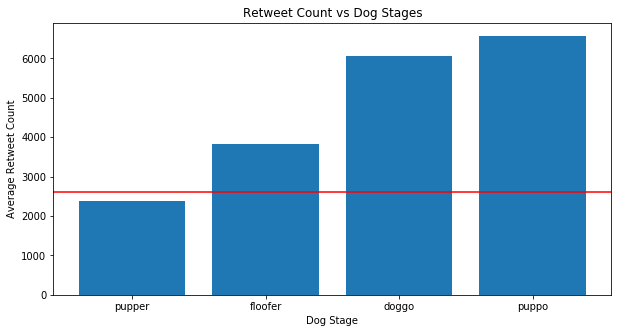

In [260]:
locations = list(range(1, retweet_series_sorted.size + 1))
heights = list(retweet_series_sorted.values)
labels = list(retweet_series_sorted.keys())
plt.figure(figsize=(10,5))
plt.bar(locations, heights, tick_label=labels)
plt.title('Retweet Count vs Dog Stages')
plt.xlabel('Dog Stage')
plt.ylabel('Average Retweet Count');
plt.axhline(retweet_mean, c='red', label="Retweet Average");

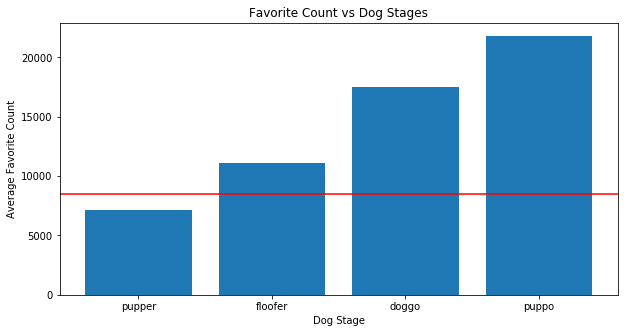

In [261]:
locations = list(range(1, favorite_series_sorted.size + 1))
heights = list(favorite_series_sorted.values)
labels = list(favorite_series_sorted.keys())
plt.figure(figsize=(10,5))
plt.bar(locations, heights, tick_label=labels)
plt.title('Favorite Count vs Dog Stages')
plt.xlabel('Dog Stage')
plt.ylabel('Average Favorite Count');
plt.axhline(favorite_mean, c='red');

1) The retweet count and the favorite count follow a similar pattern with regards to the dog stages. With puppo having the highest likes and retweets followed by doggo, floofer and pupper.
<br>
2) puppo, doggo and floofer had above average likes and retweets while pupper had below average likes and retweets.
<br>
3) These can't be taken as absolute values as I believe the dog stage classifications are very subjective.

### Analysis 2 ###

***Is there a correlation between the ratings and the retweet count?***

In [262]:
df_rating = df_twitter_archive_final[['rating_numerator', 'rating_denominator', 'retweet_count']]

In [263]:
df_rating['rating_score'] = df_rating['rating_numerator']/df_rating['rating_denominator']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [264]:
df_rating['intercept'] = 1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [265]:
lm = sm.OLS(df_rating['retweet_count'], df_rating[['intercept', 'rating_score']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          retweet_count   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.4950
Date:                Fri, 22 Mar 2019   Prob (F-statistic):              0.482
Time:                        16:06:59   Log-Likelihood:                -21423.
No. Observations:                2172   AIC:                         4.285e+04
Df Residuals:                    2170   BIC:                         4.286e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept     2599.2641    103.813     25.038      0.000    2395.682    2802.847
rating_score    16.5319     23.498      0.704      0.482     -29.549      62.613
==============================================================================
Omnibus:                     2820.829   Durbin-Watson:                   1.733
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           585549.492
Skew:                           7.040   Prob(JB):                         0.00
Kurtosis:                      82.195   Cond. No.                         4.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Since the rating_score has a high p-value, there is not enough evidence to reject the null hypothesis that the slope is 0, i.e there is no linear relationship between the rating_score and retweet count.

### Analysis 3 ###

***Which dog stage has the highest proportion of dog predictions?***

In [266]:
df_archive_predictions = pd.merge(df_twitter_archive_final,df_predictions, 
                                    on='tweet_id', how='inner')

In [267]:
df_archive_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 1990
Data columns (total 22 columns):
tweet_id              1991 non-null object
timestamp             1991 non-null object
source                1991 non-null object
text                  1991 non-null object
expanded_urls         1991 non-null object
rating_numerator      1991 non-null int64
rating_denominator    1991 non-null int64
name                  1991 non-null object
dog_stage             1991 non-null object
favorite_count        1991 non-null int64
retweet_count         1991 non-null int64
jpg_url               1991 non-null object
img_num               1991 non-null int64
p1                    1991 non-null object
p1_conf               1991 non-null float64
p1_dog                1991 non-null bool
p2                    1991 non-null object
p2_conf               1991 non-null float64
p2_dog                1991 non-null bool
p3                    1991 non-null object
p3_conf               1991 non-null floa

In [268]:
df_archive_predictions.drop(columns=['timestamp', 'source', 'text',
                            'expanded_urls', 'rating_numerator', 'img_num',
                            'rating_denominator', 'name', 'jpg_url',
                            'favorite_count', 'retweet_count'], inplace=True)

In [269]:
df_archive_predictions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1991 entries, 0 to 1990
Data columns (total 11 columns):
tweet_id     1991 non-null object
dog_stage    1991 non-null object
p1           1991 non-null object
p1_conf      1991 non-null float64
p1_dog       1991 non-null bool
p2           1991 non-null object
p2_conf      1991 non-null float64
p2_dog       1991 non-null bool
p3           1991 non-null object
p3_conf      1991 non-null float64
p3_dog       1991 non-null bool
dtypes: bool(3), float64(3), object(5)
memory usage: 145.8+ KB


In [270]:
df_archive_predictions['dog_stage'].replace('None', np.nan, inplace=True)
df_archive_predictions_split = df_archive_predictions['dog_stage'].str.split(',', expand=True) \
            .merge(df_archive_predictions, right_index = True, left_index = True) \
            .drop(['dog_stage'], axis = 1) \
            .melt(id_vars = ['p1', 'p1_conf', 'p1_dog',
                             'p2', 'p2_conf', 'p2_dog', 
                             'p3', 'p3_conf', 'p3_dog', 
                             'tweet_id'], 
                              value_name = "dog_stage") \
            .drop("variable", axis = 1) \
            .drop_duplicates(keep='first')

In [271]:
p1_prop = df_archive_predictions_split.groupby(['dog_stage'])['p1_dog'].mean()
p2_prop = df_archive_predictions_split.groupby(['dog_stage'])['p2_dog'].mean()
p3_prop = df_archive_predictions_split.groupby(['dog_stage'])['p3_dog'].mean()
print(p1_prop.keys())

Index(['doggo', 'floofer', 'pupper', 'puppo'], dtype='object', name='dog_stage')


In [272]:
p1_means = p1_prop.values
p2_means = p2_prop.values
p3_means = p3_prop.values

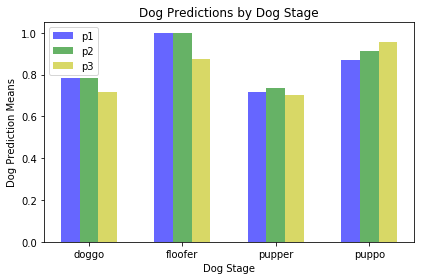

In [273]:
# create plot
# Got this idea from https://pythonspot.com/matplotlib-bar-chart/
fig, ax = plt.subplots()
index = np.arange(4)
bar_width = 0.2
opacity = 0.6
 
rects1 = plt.bar(index, p1_means, bar_width,
alpha=opacity,
color='b',
label='p1')
 
rects2 = plt.bar(index + bar_width, p2_means, bar_width,
alpha=opacity,
color='g',
label='p2')

rects3 = plt.bar(index + 2 * bar_width, p3_means, bar_width,
alpha=opacity,
color='y',
label='p3')

plt.xlabel('Dog Stage')
plt.ylabel('Dog Prediction Means')
plt.title('Dog Predictions by Dog Stage')
plt.xticks(index + bar_width, ('doggo', 'floofer', 'pupper', 'puppo'))
plt.legend()

plt.tight_layout()
plt.show()
 
plt.tight_layout()
plt.show()

Floofer had the highest dog predictions percentage, followed by puppo, doggo and pupper respectively